# ECE 570 Assignment 4 Exercise

Your Name: Ethan Glaser

## Exercise 1: Creating an image denoiser using a CNN autoencoder.
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Add code to `ConcatDataset` dataloader class that will form a paired dataset that contains a noisy image and its original image. i.e Your concatenated dataset should output noisy image and original image just like what image and label is getting extracted from our previous MNIST dataloader. **Note: Your code should not be the same with the instruction since the instruction have paired dataset that contains the labels; here you should only contains the images.**
3. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In [5]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.3):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

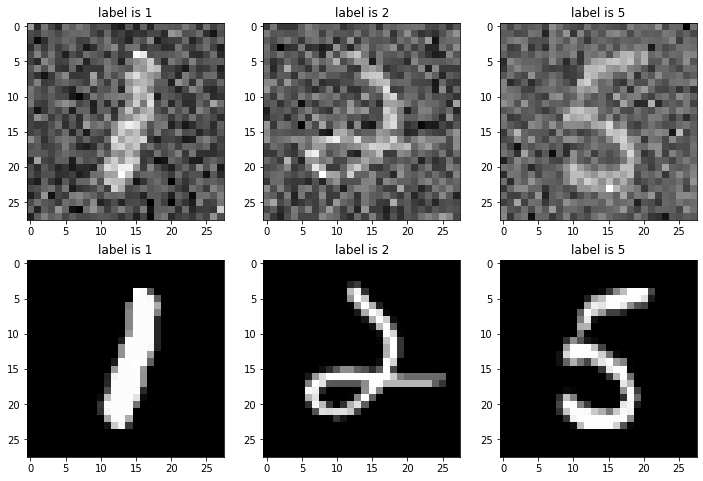

In [6]:
class ConcatDataset(torch.utils.data.Dataset):
  ###########################   <YOUR CODE>  ############################
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)
  #########################  <END YOUR CODE>  ############################

batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)
_, imgs = next(enumerate(train_loader))

###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 
fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(imgs[0][0][idx][0], cmap='gray')
  ax[0,idx].set_title(f'label is {imgs[0][1][idx]}')
  ax[1,idx].imshow(imgs[1][0][idx][0], cmap='gray')
  ax[1,idx].set_title(f'label is {imgs[0][1][idx]}')
fig.show()
#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

Epoch 1: [0/60000] Loss: 0.012207770720124245
Epoch 1: [6400/60000] Loss: 0.00556917442008853
Epoch 1: [12800/60000] Loss: 0.0032164009753614664
Epoch 1: [19200/60000] Loss: 0.002714236732572317
Epoch 1: [25600/60000] Loss: 0.0019274175865575671
Epoch 1: [32000/60000] Loss: 0.0005379253998398781
Epoch 1: [38400/60000] Loss: -0.0010539551731199026
Epoch 1: [44800/60000] Loss: -0.003964610863476992
Epoch 1: [51200/60000] Loss: -0.005842673592269421
Epoch 1: [57600/60000] Loss: -0.007243036292493343
Test result on epoch 1: Avg loss is -0.00047832196652889254
Epoch 2: [0/60000] Loss: -0.007779208943247795
Epoch 2: [6400/60000] Loss: -0.009071006439626217
Epoch 2: [12800/60000] Loss: -0.009527319110929966
Epoch 2: [19200/60000] Loss: -0.012204261496663094
Epoch 2: [25600/60000] Loss: -0.01216229610145092
Epoch 2: [32000/60000] Loss: -0.011997035704553127
Epoch 2: [38400/60000] Loss: -0.011991496197879314
Epoch 2: [44800/60000] Loss: -0.013959397561848164
Epoch 2: [51200/60000] Loss: -0.0152

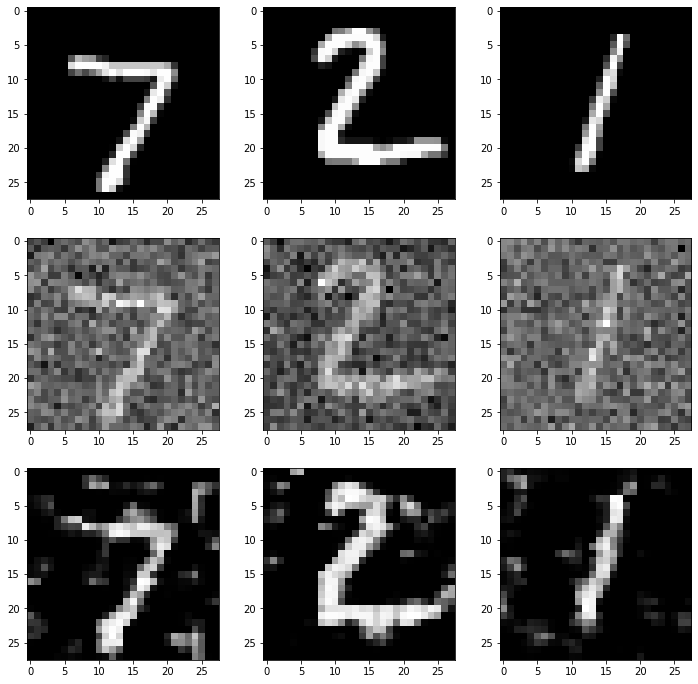

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

latent_feature = 16

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    #Encoder
    self.conv1 = nn.Conv2d(1, 256, 3, padding=1)  
    self.conv2 = nn.Conv2d(256, 16, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    
    #Decoder
    self.t_conv1 = nn.ConvTranspose2d(16, 256, 2, stride=2)
    self.t_conv2 = nn.ConvTranspose2d(256, 1, 2, stride=2)


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.t_conv1(x))
    x = torch.sigmoid(self.t_conv2(x))
          
    return x

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
AE = AutoEncoder().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()

def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (images, _) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = images[0].to(device)
    output = AE(images)
    loss = loss_fn(output, images) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images[0].to(device)
      output = AE(images)
      test_loss += loss_fn(output, images).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')


train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 2

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

batch_idx, (images, original) = next(enumerate(test_loader))
images = images[0].to(device)
output = AE(images).cpu().detach()
images = images.cpu()


fig, ax = plt.subplots(3,3)
fig.set_size_inches(12,12)

for idx in range(3):
  ax[1,idx].imshow(images[idx][0], cmap='gray')
  ax[0,idx].imshow(original[0][idx][0], cmap='gray')
  ax[2,idx].imshow(output[idx][0], cmap='gray')

fig.show()

## Exercise 2: Build a variational autoencoder that can generate MNIST images

### Task 1: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Print the size of your training and test images.

In [18]:
###########################   <YOUR CODE>  ############################
import torchvision
import torch

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Images already in [0,1]
batch_size_train, batch_size_test = 64, 1000

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))
print("Train images size: " + str(train_images.shape))
print("Test images size: " + str(test_images.shape))

#########################  <END YOUR CODE>  ############################

Train images size: torch.Size([64, 1, 28, 28])
Test images size: torch.Size([1000, 1, 28, 28])


### Task 2: VAE model
Build the VAE (variational autoencoder) model. The general code skeleton is provided here, so you only need to complete the functions in the networks.
(You may need to import certain packages before this code getting implemented)
1. Inside the `reparameterize` function you job is to output a latent vector.You should first calculate the standard deviation `std` from the log value of var `log_var`, then generate the vector in Gaussian distribution with `mu` and `std`. 
2. Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [20]:
import torch.nn as nn
import torch.nn.functional as F

latent_feature = 16

class our_VAE(nn.Module):
  def __init__(self):
    super(our_VAE, self).__init__()

    # encoder
    self.en_fc1 = nn.Linear(in_features=784, out_features=512)
    self.en_fc2 = nn.Linear(in_features=512, out_features=latent_feature*2)

    # decoder
    self.de_fc1 = nn.Linear(in_features=latent_feature, out_features=512)
    self.de_fc2 = nn.Linear(in_features=512, out_features=784)

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var)
    """
    ###########################   <YOUR CODE>  ############################
    std = log_var.mul(0.5).exp_()
    if torch.cuda.is_available():
        eps = torch.cuda.FloatTensor(std.size()).normal_()
    else:
        eps = torch.FloatTensor(std.size()).normal_()
    eps = Variable(eps)
    sample = eps.mul(std).add_(mu)
    #########################  <END YOUR CODE>  ############################
    return sample

  
  def forward(self, x):
    """
    :param x: input variables

    You should return a sample with gaussian distribution N(mu, var)
    """
    # encoding layers
    x = x.view(-1, 784)
    x = F.relu(self.en_fc1(x))
    x = self.en_fc2(x).view(-1, 2, latent_feature)
    ###########################   <YOUR CODE>  ############################
    # Extract mu and log_var from x
    mu = x[:,0,:]
    log_var = x[:,1,:]
    #########################  <END YOUR CODE>  ############################
    z = self.reparameterize(mu, log_var)

    # decoding layers
    x = F.relu(self.de_fc1(z))
    x = torch.sigmoid(self.de_fc2(x))
    x = x.view(-1, 1, 28, 28)
    
    return x, mu, log_var

### Task 3: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
Basically you need to calculate two part and then add them together.
While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
This reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See `torch.nn.functional.binary_cross_entropy` https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy.
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If both are Gaussian, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$  

The class slides provide some derivation of this.  You can also look at the original paper or this blog post for some more information: [Variational Autoencoder](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

Your task here is simply write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var, and returns the loss.


In [27]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  ###########################   <YOUR CODE>  ############################
  BCE = F.binary_cross_entropy(output, images, reduction='sum')
  KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  KLD /= batch_size_train * 784
  loss =  BCE + KLD 
  #########################  <END YOUR CODE>  ############################
  return loss

### Task 4: Train and visualize output
1. Train your model with an appropriate optimizer and above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should show at three pairs of images where each pair consists of an original test image and its VAE reconstructed version.


Epoch 1: [0/60000] Loss: 547.9290771484375
Epoch 1: [6400/60000] Loss: 218.02243041992188
Epoch 1: [12800/60000] Loss: 202.25640869140625
Epoch 1: [19200/60000] Loss: 201.37742614746094
Epoch 1: [25600/60000] Loss: 188.97476196289062
Epoch 1: [32000/60000] Loss: 164.47720336914062
Epoch 1: [38400/60000] Loss: 156.7039031982422
Epoch 1: [44800/60000] Loss: 145.5674285888672
Epoch 1: [51200/60000] Loss: 133.57374572753906
Epoch 1: [57600/60000] Loss: 133.18212890625
Test result on epoch 1: Avg loss is 128.91764296875
Epoch 2: [0/60000] Loss: 122.50675201416016
Epoch 2: [6400/60000] Loss: 129.80380249023438
Epoch 2: [12800/60000] Loss: 126.70732116699219
Epoch 2: [19200/60000] Loss: 119.9212646484375
Epoch 2: [25600/60000] Loss: 120.52096557617188
Epoch 2: [32000/60000] Loss: 105.38056945800781
Epoch 2: [38400/60000] Loss: 107.44188690185547
Epoch 2: [44800/60000] Loss: 110.93773651123047
Epoch 2: [51200/60000] Loss: 101.6758041381836
Epoch 2: [57600/60000] Loss: 96.67505645751953
Test re

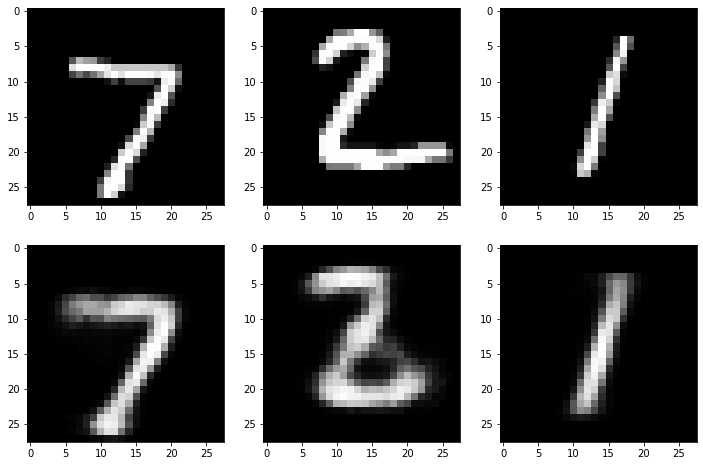

In [30]:
###########################   <YOUR CODE>  ############################
from torch.autograd import Variable

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
VAE = our_VAE().to(device)
optimizer = optim.Adam(VAE.parameters(), lr=1e-4)

def train(epoch, device):

  VAE.train() # we need to set the mode for our model

  for batch_idx, (images, _) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = images.to(device)
    output, mu, log_var = VAE(images)
    loss = vae_loss(output, mu, log_var, images) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  VAE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.to(device)
      output, mu, log_var = VAE(images)
      output = output.to(device)
      loss = vae_loss(output, mu, log_var, images)
      test_loss += loss.item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')


train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 2

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

batch_idx, images = next(enumerate(test_loader))
images = images[0].to(device)
output = VAE(images)[0].cpu().detach()
images = images.cpu()


fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[1,idx].imshow(output[idx][0], cmap='gray')

fig.show()
#########################  <END YOUR CODE>  ###########################